# Task 2: ideal pendulum
Sam Greydanus

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-pend'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

In [2]:
# %%
import numpy as np
import autograd
import autograd.numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
solve_ivp = scipy.integrate.solve_ivp
import seaborn as sns
from statsmodels.api import OLS
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso,LinearRegression


In [19]:
3/(n_points-1)

0.028846153846153848

In [12]:
t_span, timescale = [0, 3], 35
n_points = int(timescale * (t_span[1] - t_span[0]))
np.linspace(t_span[0], t_span[1], n_points)

array([0.        , 0.02884615, 0.05769231, 0.08653846, 0.11538462,
       0.14423077, 0.17307692, 0.20192308, 0.23076923, 0.25961538,
       0.28846154, 0.31730769, 0.34615385, 0.375     , 0.40384615,
       0.43269231, 0.46153846, 0.49038462, 0.51923077, 0.54807692,
       0.57692308, 0.60576923, 0.63461538, 0.66346154, 0.69230769,
       0.72115385, 0.75      , 0.77884615, 0.80769231, 0.83653846,
       0.86538462, 0.89423077, 0.92307692, 0.95192308, 0.98076923,
       1.00961538, 1.03846154, 1.06730769, 1.09615385, 1.125     ,
       1.15384615, 1.18269231, 1.21153846, 1.24038462, 1.26923077,
       1.29807692, 1.32692308, 1.35576923, 1.38461538, 1.41346154,
       1.44230769, 1.47115385, 1.5       , 1.52884615, 1.55769231,
       1.58653846, 1.61538462, 1.64423077, 1.67307692, 1.70192308,
       1.73076923, 1.75961538, 1.78846154, 1.81730769, 1.84615385,
       1.875     , 1.90384615, 1.93269231, 1.96153846, 1.99038462,
       2.01923077, 2.04807692, 2.07692308, 2.10576923, 2.13461

In [11]:
t_span, timescale = [0, 1/2], 35
n_points = int(timescale * (t_span[1] - t_span[0]))
np.arange(t_span[0], n_points, t_span[1])

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5])

## Set some notebook constants

In [35]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

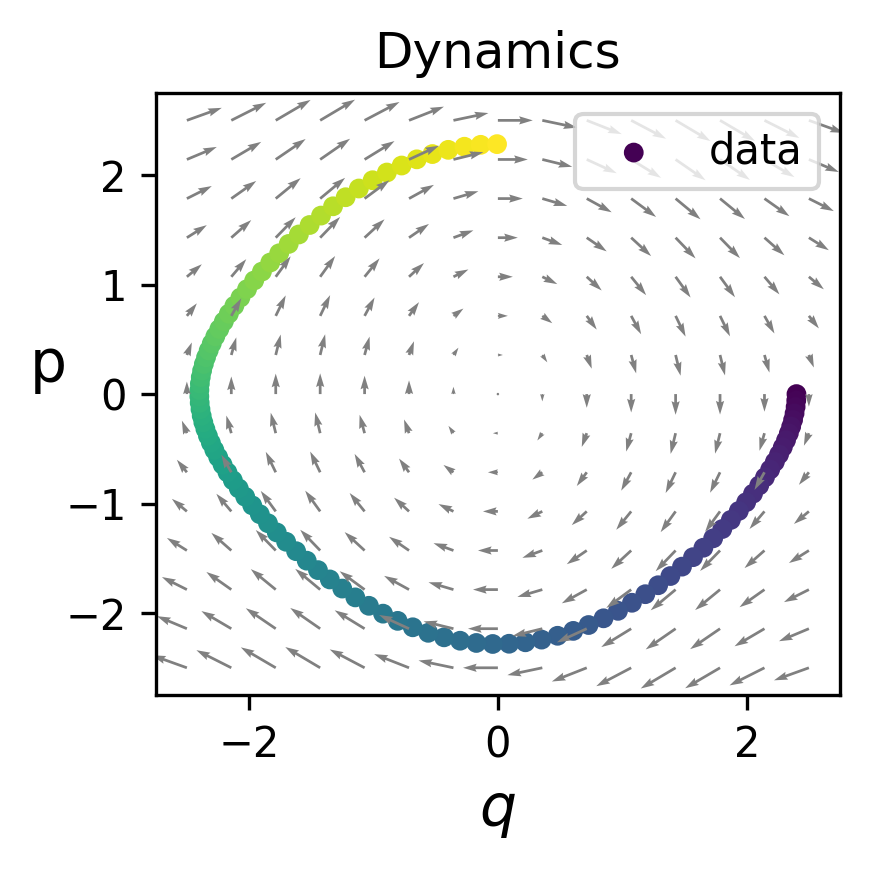

In [36]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

## Construct models

In [53]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'new_loss-hnn'
    path = "{}/pend{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [38]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [39]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [54]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# get their vector fields
R = 2.6
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
data = get_dataset(radius=2.0)
base_field = get_vector_field(base_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,28]
y0 = np.asarray([2.1, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

C:\Users\aksha\AppData\Local\Temp\ipykernel_27468\2130957178.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


## Plot results

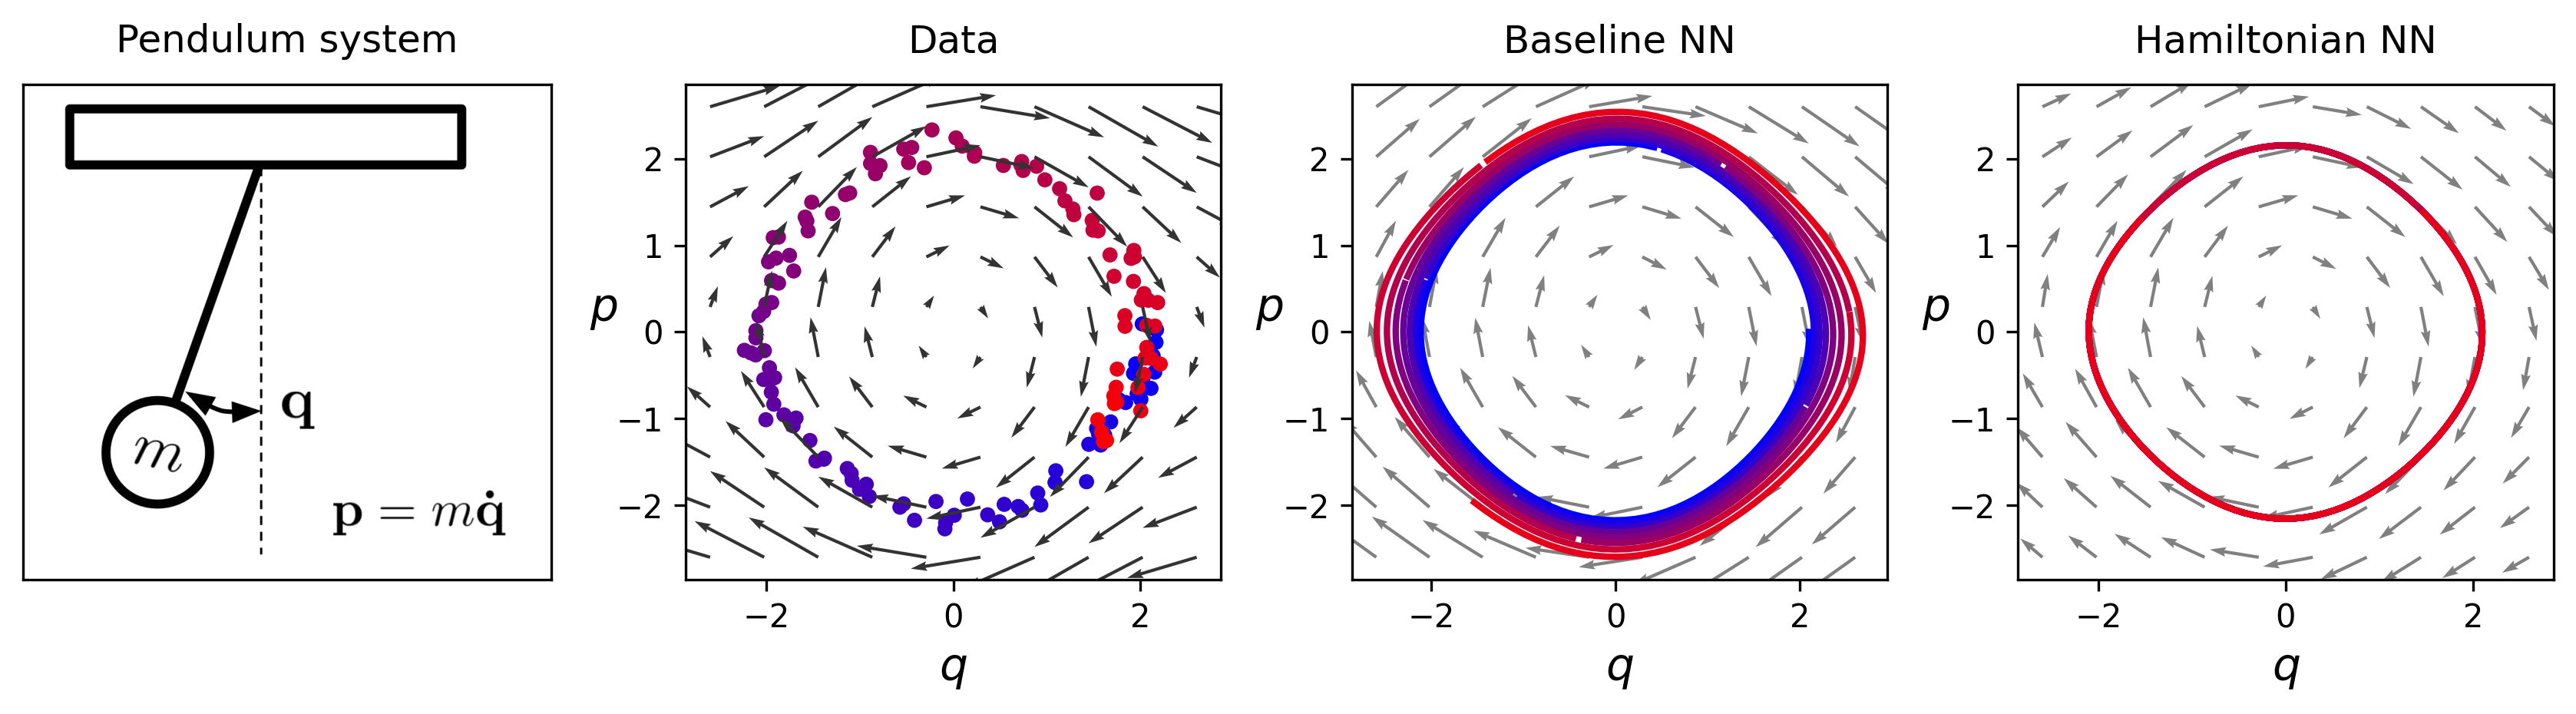

In [55]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/pendulum.png')
plt.imshow(schema)
plt.title("Pendulum system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(t_span=[0,4], radius=2.1, y0=y0)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [42]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_eval=None):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    return true_x, base_x, hnn_x

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

In [43]:
#My code
def H(p, q, k=1, m=1):
    # Here k is not used; we directly use the pendulum parameters.
    return 3*(1 - np.cos(q)) + (p**2)

def dH_dq(p, q, k=1, m=1): 
    # dH/dq = 6*sin(q)
    return 3*np.sin(q)
def dH_dp(p, q, k=1, m=1):
    # dH/dp = p
    return 2*p
def partial_p_features(q, p, n):
    """
    Returns a vector of features corresponding to the partial derivative of H with respect to p.
    For each term, feature = l * q^i * p^(l-1) if l>0, else 0.
    """
    q = np.float64(q)
    p = np.float64(p)
    feats = []
    for i in range(0, n+1):
        for l in range(0, n - i + 1):
            if l == 0:
                feats.append(0.0)
            else:
                feats.append(l * (q**i) * (p**(l-1)))
    return np.array(feats, dtype=np.float64)

def partial_q_features(q, p, n):
    """
    Returns a vector of features corresponding to the partial derivative of H with respect to q.
    For each term, feature = i * q^(i-1) * p^l if i>0, else 0.
    """
    q = np.float64(q)
    p = np.float64(p)
    feats = []
    for i in range(0, n+1):
        for l in range(0, n - i + 1):
            if i == 0:
                feats.append(0.0)
            else:
                feats.append(i * (q**(i-1)) * (p**l))
    return np.array(feats, dtype=np.float64)

def build_feature_matrix(X, Y, n):
    """
    Given:
      X shape = (N, 2) => [q, p]
      Y shape = (N, 2) => [dqdt, dpdt]
    Returns:
      X_big shape = (2N, M) and y_big shape = (2N,)
    where first N rows correspond to partial wrt p (label = dqdt),
          second N rows correspond to partial wrt q (label = -dpdt).
    """
    N = len(X)
    X_rows = []
    y_rows = []
    for i in range(N):
        q, p = X[i]
        dq, dp = Y[i]
        # partial wrt p => label dq
        X_rows.append(partial_p_features(q, p, n))
        y_rows.append(dq)
        # partial wrt q => label -dp
        X_rows.append(partial_q_features(q, p, n))
        y_rows.append(-dp)
    X_rows = np.array(X_rows)
    return X_rows[:, 1:], np.array(y_rows)

def build_transformed_matrix(X, n):
    X_transformed = []
    for j in range(X.shape[0]):
        x = []
        for i in range(0, n+1):
            for l in range(0, n - i + 1):
                x.append((X[j][0]**i) * (X[j][1]**l))
        # Drop the constant term to mimic training setup
        X_transformed.append(np.array(x)[1:])
    return np.array(X_transformed)


In [44]:
train_x, train_y, test_x, test_y = data['x'],data['dx'], data['test_x'],data['test_dx']
best_n = None
best_lambda = None
best_aic = np.inf
for n in range(2,6):
    X_train_big, y_train_big = build_feature_matrix(train_x, train_y, n)
    X_test_big,  y_test_big  = build_feature_matrix(test_x, test_y, n)
    best_lam , low_mse = None, np.inf
    for lambdas in np.logspace(-3, 0, 5):
        model = Lasso(alpha=lambdas)
        model.fit(X_train_big, y_train_big)
        y_pred = model.predict(X_test_big)
        mse = np.sum((y_pred - y_test_big)**2) / len(y_test_big)
        # print(f"MSE {mse} for lambda {lambdas}")
        if low_mse > mse:
            best_lam = lambdas
            low_mse = mse
    model = Lasso(alpha=best_lam)
    model.fit(X_train_big, y_train_big)
    k = np.sum(model.coef_ != 0)  # Non-zero features (+1 if intercept)
    mse_train = np.sum((y_pred - model.predict(X_test_big))**2) / len(y_test_big)
    aic = len(y_test_big) * np.log(low_mse) + 2 * k
    print(f"Model with best AIC {aic} and lambda {best_lam} for polynomial degree {n}")
    if aic < best_aic:
        best_aic = aic
        best_n = n
        best_lambda = best_lam
n = best_n
X_train_big, y_train_big = build_feature_matrix(train_x, train_y, best_n)
X_test_big,  y_test_big  = build_feature_matrix(test_x, test_y, best_n)
model = Lasso(alpha=best_lambda)
model.fit(X_train_big, y_train_big)
print("Learned coefficients:", model.coef_)

Model with best AIC -16632.991194108385 and lambda 0.001 for polynomial degree 2
Model with best AIC -16619.82334087946 and lambda 0.005623413251903491 for polynomial degree 3
Model with best AIC -35798.838467413225 and lambda 0.001 for polynomial degree 4
Model with best AIC -35788.57257856626 and lambda 0.001 for polynomial degree 5
Learned coefficients: [-0.00000000e+00  1.07474814e+00 -0.00000000e+00 -1.02943364e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  3.14516263e-04
  1.45347333e+00 -3.28500844e-04 -1.60898684e-02 -2.66913809e-04
 -4.86609970e-04 -9.46917604e-02]


In [45]:
#MY code
def H_wrapper(q, p):
    # Our H function expects (p, q), so swap:
    # return H(p, q, k, 1)
    return hamiltonian_fn(q,p)

def predicted_hamiltonian(q, p):
    # Build feature vector for state [q, p]
    X = np.array([[q, p]])
    X = build_transformed_matrix(X, n)
    return (X @ model.coef_)[0]

# Hamilton's equations: dq/dt = ∂H/∂p, dp/dt = -∂H/∂q
def hamiltonian_system(t, state, hamiltonian):
    # Use state ordering: state = [q, p]
    q, p = state
    delta = 1e-5
    # Finite-difference approximations:
    dH_dp = (hamiltonian(q, p + delta) - hamiltonian(q, p - delta)) / (2 * delta)
    dH_dq = (hamiltonian(q + delta, p) - hamiltonian(q - delta, p)) / (2 * delta)
    return [dH_dp, -dH_dq]



In [46]:
data = get_dataset()
data['x'].shape

(5250, 2)

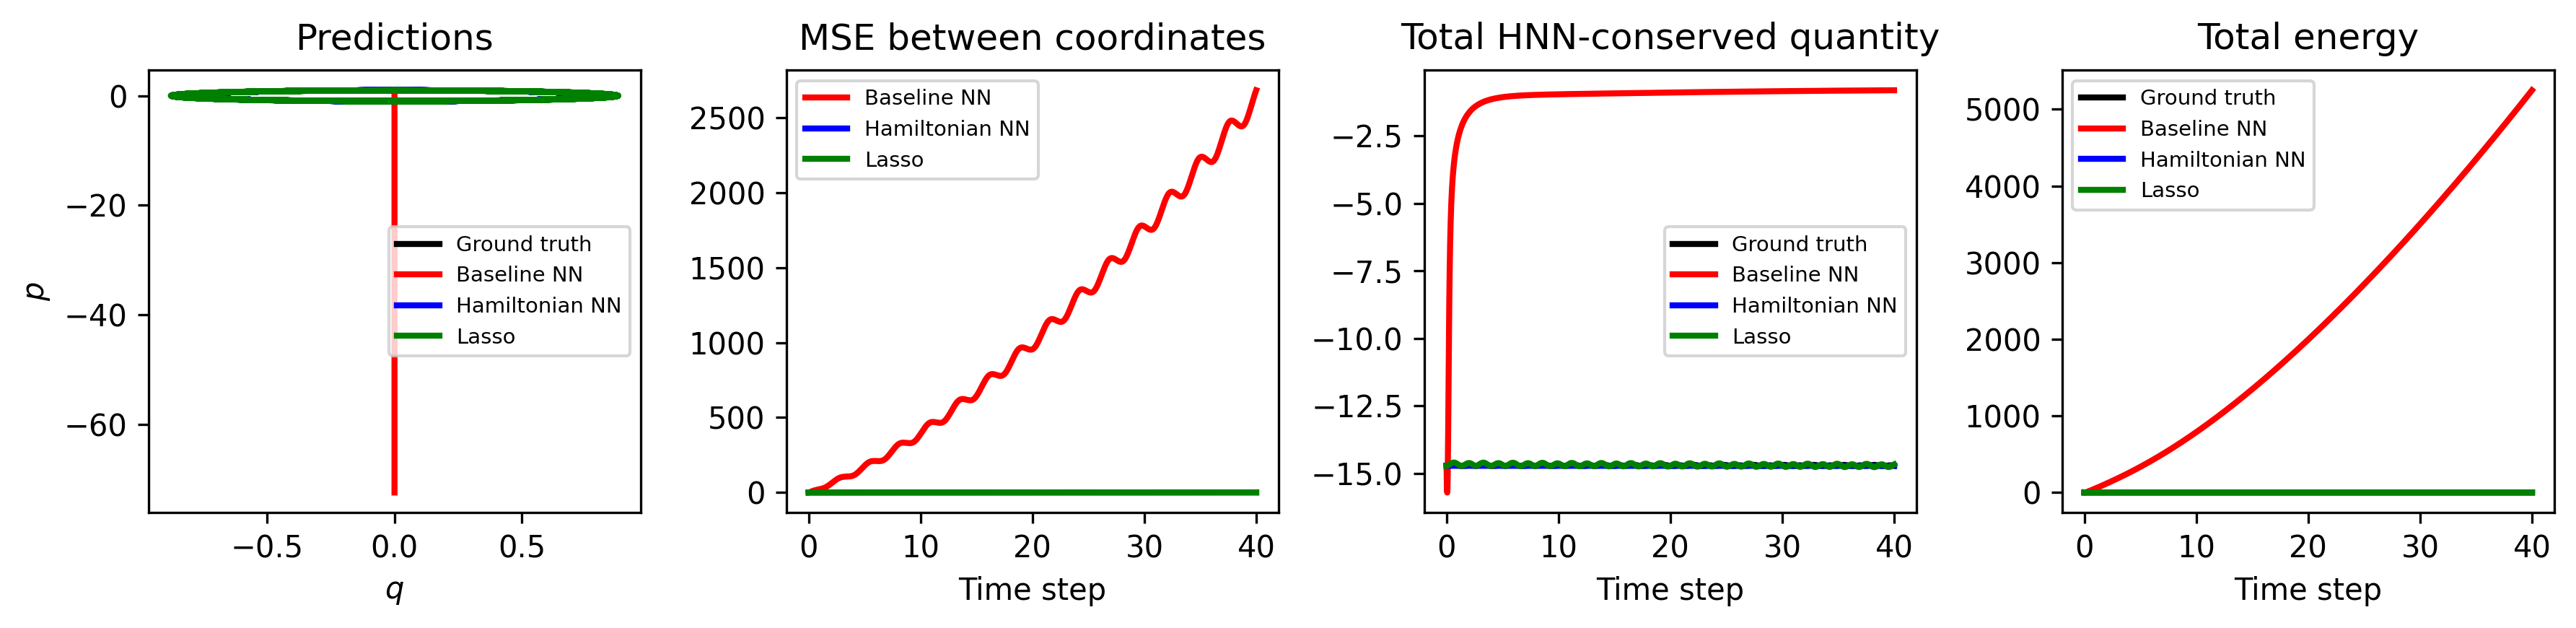

In [50]:
x0 = np.asarray([0.0, 1.0])

# integration
t_span=[0,40]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
sol_predicted = solve_ivp(hamiltonian_system, t_span, x0, args=(predicted_hamiltonian,), t_eval=t_eval)
lasso_x = sol_predicted.y.T
true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

# plotting
tpad = 7

fig = plt.figure(figsize=[12,3], dpi=DPI)
plt.subplot(1,4,1)
plt.title("Predictions", pad=tpad) ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.plot(lasso_x[:,0], lasso_x[:,1], 'g-', label='Lasso', linewidth=2)
# plt.xlim(-2.5,4) ; plt.ylim(-2.5,4)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.plot(t_eval, ((true_x-lasso_x)**2).mean(-1), 'g-', label='Lasso', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = hnn_model(torch.Tensor(true_x))[1].detach().numpy().squeeze()
base_hq = hnn_model(torch.Tensor(base_x))[1].detach().numpy().squeeze()
hnn_hq = hnn_model(torch.Tensor(hnn_x))[1].detach().numpy().squeeze()
# lasso_hq = np.array([predicted_hamiltonian(qp[0],qp[1]) for qp in lasso_x])
lasso_hq = hnn_model(torch.Tensor(lasso_x))[1].detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.plot(t_eval, lasso_hq, 'g-', label='Lasso', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,4)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_x])
base_e = np.stack([hamiltonian_fn(c) for c in base_x])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
lasso_e = np.array([hamiltonian_fn(c) for c in lasso_x])
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.plot(t_eval, lasso_e, 'g-', label='Lasso', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()
fig.savefig('{}/pend-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [48]:
# splits = 5
# samples = 3
# losses = {'base_energy' : [], 'hnn_energy' : []}
# t_eval = np.linspace(t_span[0], t_span[1], 100)

# _tmp = [] # for computing batched means
# for i in range(splits*samples):
#     x0 = np.random.rand(2)*1.6 - .8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
#     x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
#     true_x, base_x, hnn_x = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)
    
#     losses['base_energy'] += [ energy_loss(true_x, base_x) ]
#     losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
#     print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [49]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)


print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_conf(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_conf(losses['hnn_energy'], splits))
     )

NameError: name 'losses' is not defined